In [2]:
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.util.fits import *
from collections import Counter
from astrometry.libkd.spherematch import match_radec
import fitsio
from glob import glob
import sys
import os
#from astrometry.util.starutil import *
#from astrometry.util.starutil_numpy import *
#from astrometry.util.util import Sip
import pickle

In [2]:
!ls /global/cfs/cdirs/desi/spectro/redux/loa

calibnight	    exposure_tables    preproc		    tiles-loa.csv
exposures	    healpix	       redux_loa.sha256sum  tiles-loa.fits
exposures-loa.csv   inventory-loa.txt  run		    zcatalog
exposures-loa.fits  nightqa	       tiles


In [3]:
#!ls /global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/{bright,dark}/?/

In [6]:
if False:
    hps = np.arange(5000)
    rr_bright_fns = []
    for hp in hps:
        fn = '/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/bright/%i/%i/redrock-main-bright-%i.fits' % (hp//100, hp, hp)
        if os.path.exists(fn):
            rr_bright_fns.append(fn)

In [4]:
rr_bright_fns = glob('/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/bright/*/*/redrock-main-bright-*.fits')
rr_bright_fns.sort()
len(rr_bright_fns)

17908

In [7]:
fns = rr_bright_fns
print(len(fns), 'files')
gals = []
fm = []
for ifn,fn in enumerate(fns):
    g = fits_table(fn)
    f = fits_table(fn, hdu=2)
    # Select redshifts so that the [OIII] line is in the R camera!  R wavelengths 5760 - 7620 -> z 0.15
    I = np.flatnonzero((g.z > 0.15) * (g.z < 0.5) * (g.zwarn == 0))
    if len(I) == 0:
        continue
    gals.append(g[I])
    fm.append(f[I])
    if ifn % 10 == 0:
        print('.',end='')
print()
gals = merge_tables(gals)
fm = merge_tables(fm)
gals.add_columns_from(fm)
len(gals)

17908 files
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

9571025

In [8]:
gals.writeto('/pscratch/sd/d/dstn/galaxy-sample.fits')

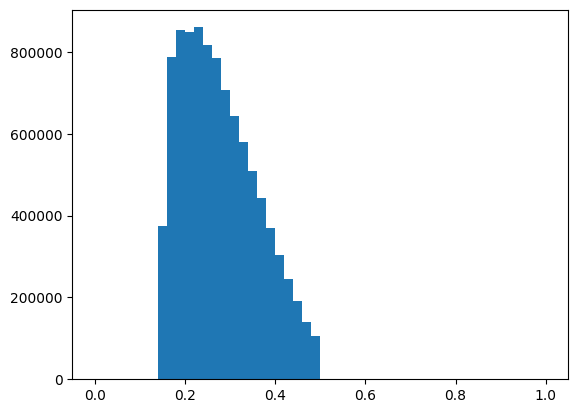

In [9]:
plt.hist(gals.z, range=(0, 1), bins=50);

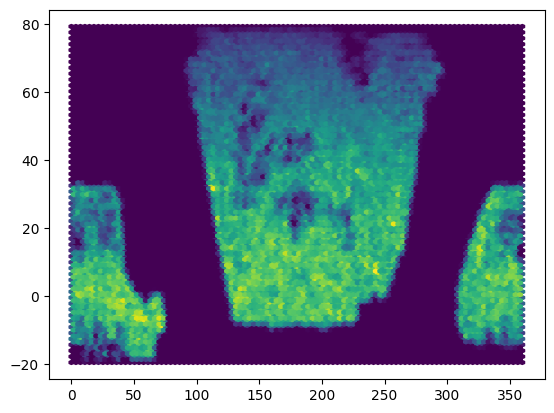

In [11]:
plt.hexbin(gals.target_ra, gals.target_dec);

In [14]:
#fns = glob('/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/dark/?/*/redrock-main-dark-*.fits')
rr_dark_fns = [fn.replace('bright', 'dark') for fn in rr_bright_fns]
fns = rr_dark_fns
print(len(fns), 'files')
spec = []
fm = []
for ifn,fn in enumerate(fns):
    if not os.path.exists(fn):
        continue
    s = fits_table(fn)
    f = fits_table(fn, hdu=2)
    I = np.flatnonzero((f.coadd_fiberstatus & 0x2) != 0)
    if len(I) == 0:
        continue
    spec.append(s[I])
    fm.append(f[I])
    if ifn % 10 == 0:
        print('.',end='')
print()
spec = merge_tables(spec)
fm = merge_tables(fm)
spec.add_columns_from(fm)
len(spec)

17908 files
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

5059810

In [15]:
spec.writeto('/pscratch/sd/d/dstn/stuck-sample.fits')

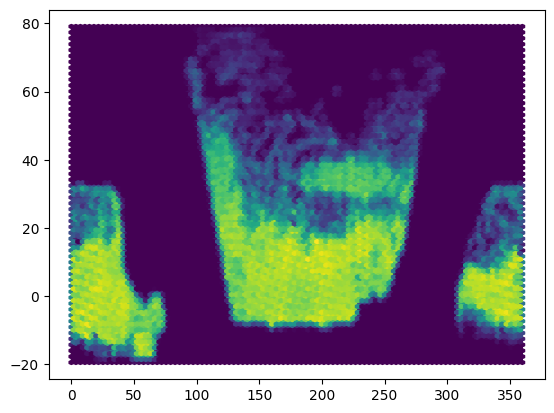

In [16]:
plt.hexbin(spec.target_ra, spec.target_dec);

In [13]:
print('STUCK_POSITIONER')
Counter((spec.coadd_fiberstatus & 0x2) != 0)

STUCK_POSITIONER


Counter({False: 2602180, True: 547326})

In [14]:
I = np.flatnonzero((spec.coadd_fiberstatus & 0x2) != 0)
print(len(I), 'STUCK')
stuck = spec[I]

547326 STUCK


In [15]:
I = np.flatnonzero((spec.coadd_fiberstatus & 0x2) == 0)
unstuck = spec[I]

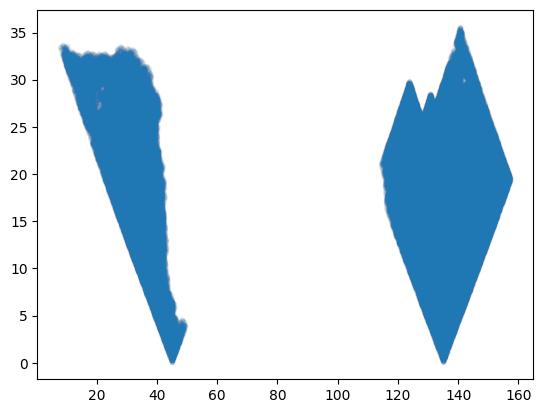

In [16]:
plt.plot(stuck.target_ra, stuck.target_dec, '.', alpha=0.01);

In [17]:
print('STUCK fibers: UNASSIGNED')
Counter(stuck.coadd_fiberstatus & 0x1)

STUCK fibers: UNASSIGNED


Counter({0: 393413, 1: 153913})

In [18]:
print('STUCK fibers: SKY target')
Counter((stuck.desi_target & (1<<32)) != 0)

STUCK fibers: SKY target


Counter({False: 547326})

In [19]:
# fa_type is whether the fiber-assignment code treated the fiber as science/sky/etc
#Counter(spec.fa_type)

In [20]:
'''
FA_TYPE
#define TARGET_TYPE_SCIENCE 1
#define TARGET_TYPE_STANDARD 2
#define TARGET_TYPE_SKY 4
#define TARGET_TYPE_SAFE 8
#define TARGET_TYPE_SUPPSKY 16
''';

In [21]:
print('Science')
print(Counter((stuck.fa_type & 1) != 0))
print('Standard')
print(Counter((stuck.fa_type & 2) != 0))
print('Sky')
print(Counter((stuck.fa_type & 4) != 0))
print('Safe')
print(Counter((stuck.fa_type & 8) != 0))
print('Suppsky')
print(Counter((stuck.fa_type & 16) != 0))

Science
Counter({False: 547326})
Standard
Counter({False: 547326})
Sky
Counter({True: 393413, False: 153913})
Safe
Counter({False: 547326})
Suppsky
Counter({False: 547326})


In [22]:
stuck_sky = stuck[(stuck.coadd_fiberstatus & 0x1) == 0]
stuck_nonsky = stuck[(stuck.coadd_fiberstatus & 0x1) != 0]
len(stuck_sky), len(stuck_nonsky)

(393413, 153913)

In [23]:
print('un-STUCK fibers: SKY target')
Counter((unstuck.desi_target & (1<<32)) != 0)

un-STUCK fibers: SKY target


Counter({False: 2557967, True: 44213})

In [24]:
def viewer_link(obj):
    print('https://www.legacysurvey.org/viewer-desi/?ra=%.4f&dec=%.4f&zoom=15&mark=%.4f,%.4f' %
          (obj.target_ra, obj.target_dec, obj.target_ra, obj.target_dec))

In [25]:
viewer_link(stuck_sky[0])
viewer_link(stuck_nonsky[2])

https://www.legacysurvey.org/viewer-desi/?ra=44.9310&dec=0.1206&zoom=15&mark=44.9310,0.1206
https://www.legacysurvey.org/viewer-desi/?ra=45.5050&dec=0.5456&zoom=15&mark=45.5050,0.5456


In [26]:
Counter(stuck_sky.zwarn == 0)

Counter({False: 393413})

In [27]:
Counter(stuck_nonsky.zwarn == 0)

Counter({False: 153913})

In [28]:
Counter(stuck_sky.zwarn == 1)

Counter({False: 379953, True: 13460})

In [29]:
I = np.flatnonzero(stuck_sky.zwarn == 1)
viewer_link(stuck_sky[I[0]])

https://www.legacysurvey.org/viewer-desi/?ra=44.7302&dec=0.4745&zoom=15&mark=44.7302,0.4745


In [30]:
Counter(stuck_sky.spectype[I])

Counter({'GALAXY': 13230, 'STAR': 17, 'QSO': 213})

In [5]:
spec = fits_table('/pscratch/sd/d/dstn/stuck-sample.fits')
gals = fits_table('/pscratch/sd/d/dstn/galaxy-sample.fits')

In [6]:
stuck = spec

In [7]:
len(stuck), len(gals)

(5059810, 9571025)

In [8]:
sky_sample = stuck

In [9]:
# do a full matching just to get the median distance?  yeah ok cool
#I,J,d = match_radec(stuck_sky.target_ra, stuck_sky.target_dec, gals.target_ra, gals.target_dec, 2./60.)
#I,J,d = match_radec(sky_sample.target_ra, sky_sample.target_dec, gals.target_ra, gals.target_dec, 2./60.)
#med_dist = np.median(d)
#med_dist * 60.
#med_dist = 1.44 / 60.

11716985 matches


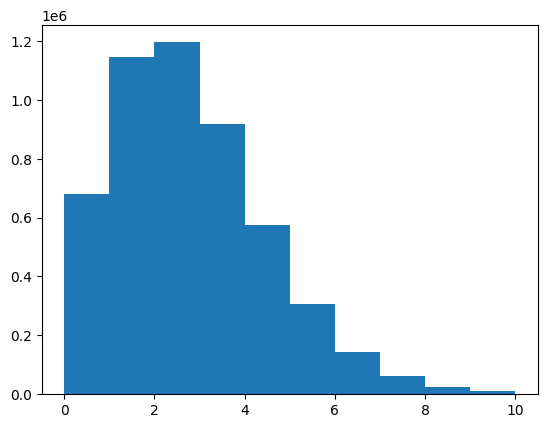

In [10]:
#Imatch = match_radec(stuck_sky.target_ra, stuck_sky.target_dec, gals.target_ra, gals.target_dec, 2./60., indexlist=True)
Imatch = match_radec(sky_sample.target_ra, sky_sample.target_dec, gals.target_ra, gals.target_dec, 2./60., indexlist=True)
print(sum([len(ii) for ii in Imatch if ii is not None]), 'matches')
plt.hist([len(ii) if ii is not None else 0 for ii in Imatch], range=(0,10), bins=10);

In [35]:
Imatch[0]

[357, 170]

In [475]:
##
#   Grab lines from the galaxy sample, as a test of the procedure...
##
co_bright_fns = [fn.replace('/redrock-', '/coadd-') for fn in rr_bright_fns]
fns = co_bright_fns
print(len(fns), 'files')
o3_fluxes = []
o3_ivars = []

o2_fluxes = []
o2_ivars = []

ha_fluxes = []
ha_ivars = []

# 3726-3729 [OII] lines
# 6562      Halpha
# 6583      [NII]

keep_targetids = gals.targetid
tid_map = dict([(t,i) for i,t in enumerate(gals.targetid)])
for fn in fns[:500]:
    fibermap = fits_table(fn)
    I = np.flatnonzero(np.isin(fibermap.targetid, keep_targetids))
    if len(I) == 0:
        continue
    F = fitsio.FITS(fn)
    targetids = fibermap.targetid[I]
    ras = fibermap.target_ra[I]
    decs = fibermap.target_dec[I]
    b_wave = F['B_WAVELENGTH'].read()
    b_flux = F['B_FLUX'].read()[I, :]
    b_ivar = F['B_IVAR'].read()[I, :]
    r_wave = F['R_WAVELENGTH'].read()
    r_flux = F['R_FLUX'].read()[I, :]
    r_ivar = F['R_IVAR'].read()[I, :]
    z_wave = F['Z_WAVELENGTH'].read()
    z_flux = F['Z_FLUX'].read()[I, :]
    z_ivar = F['Z_IVAR'].read()[I, :]
    for ispec,(targetid,ra,dec) in enumerate(zip(targetids, ras, decs)):
        igal = tid_map[targetid]
        z = gals.z[igal]

        # [OII]
        target_restframe = 3726.
        target_wave = target_restframe * (1. + z)
        iwave = np.argmin(np.abs(b_wave - target_wave))
        S = 40
        #assert((iwave >= S) * (iwave < len(b_wave)-S))
        if (iwave >= S) and (iwave < len(b_wave)-S):
            f   = b_flux[ispec, iwave-S : iwave+S+1]
            fiv = b_ivar[ispec, iwave-S : iwave+S+1]
            o2_fluxes.append(f)
            o2_ivars.append(fiv)
        
        # [OIII]
        target_restframe = 5007.
        target_wave = target_restframe * (1. + z)
        iwave = np.argmin(np.abs(r_wave - target_wave))
        S = 40
        #assert((iwave >= S) * (iwave < len(r_wave)-S))
        if (iwave >= S) and (iwave < len(r_wave)-S):
            f   = r_flux[ispec, iwave-S : iwave+S+1]
            fiv = r_ivar[ispec, iwave-S : iwave+S+1]
            o3_fluxes.append(f)
            o3_ivars.append(fiv)

        # H-alpha
        target_restframe = 6562.
        target_wave = target_restframe * (1. + z)
        iwave = np.argmin(np.abs(z_wave - target_wave))
        S = 40
        #assert((iwave >= S) * (iwave < len(z_wave)-S))
        if (iwave >= S) and (iwave < len(r_wave)-S):
            f   = z_flux[ispec, iwave-S : iwave+S+1]
            fiv = z_ivar[ispec, iwave-S : iwave+S+1]
            ha_fluxes.append(f)
            ha_ivars.append(fiv)

    print('.', end='')
    sys.stdout.flush()

#    if len(o2_fluxes) > 500:
#        break

print()

gal_o3_fluxes = np.vstack(o3_fluxes)
gal_o3_ivars  = np.vstack(o3_ivars)
gal_o2_fluxes = np.vstack(o2_fluxes)
gal_o2_ivars  = np.vstack(o2_ivars)
gal_ha_fluxes = np.vstack(ha_fluxes)
gal_ha_ivars  = np.vstack(ha_ivars)


1525 files
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [476]:
o3_fluxes.shape

(182726, 81)

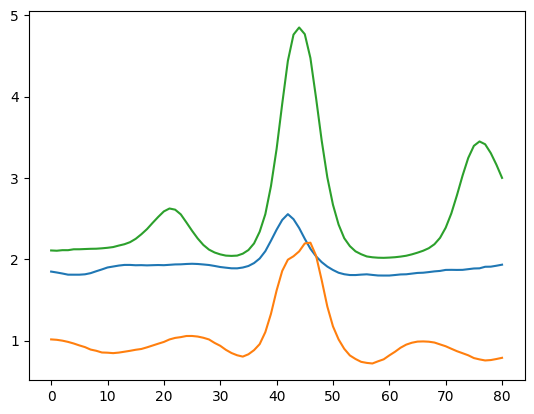

In [477]:
plt.plot(np.median(gal_o3_fluxes, axis=0));
plt.plot(np.median(gal_o2_fluxes, axis=0));
plt.plot(np.median(gal_ha_fluxes, axis=0));

In [478]:
b_wave[1] - b_wave[0], r_wave[1] - r_wave[0], z_wave[1] - z_wave[0]

(0.8000000000001819, 0.8000000000001819, 0.8000000000001819)

In [495]:
o2_dw = b_wave[1] - b_wave[0]
o2_nw = gal_o2_fluxes.shape[1]
o2_delta_wave = o2_dw * (np.arange(o2_nw) - o2_nw//2)

o3_dw = r_wave[1] - r_wave[0]
o3_nw = gal_o3_fluxes.shape[1]
o3_delta_wave = o3_dw * (np.arange(o3_nw) - o3_nw//2)

ha_dw = z_wave[1] - z_wave[0]
ha_nw = gal_ha_fluxes.shape[1]
ha_delta_wave = ha_dw * (np.arange(ha_nw) - ha_nw//2)

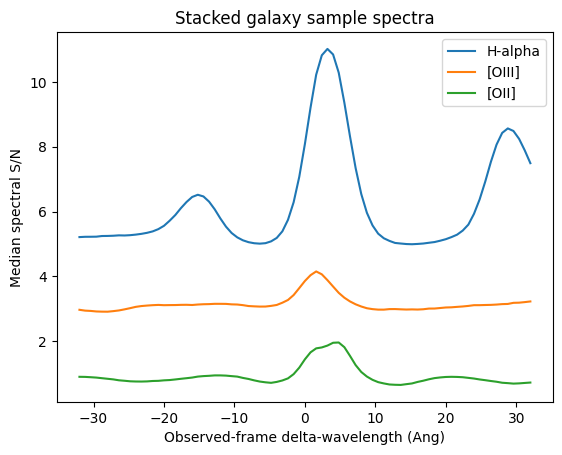

In [496]:
plt.plot(ha_delta_wave, np.median(gal_ha_fluxes * np.sqrt(gal_ha_ivars), axis=0), label='H-alpha')
plt.plot(o3_delta_wave, np.median(gal_o3_fluxes * np.sqrt(gal_o3_ivars), axis=0), label='[OIII]')
plt.plot(o2_delta_wave, np.median(gal_o2_fluxes * np.sqrt(gal_o2_ivars), axis=0), label='[OII]')
plt.legend();
plt.xlabel('Observed-frame delta-wavelength (Ang)')
plt.ylabel('Median spectral S/N')
plt.title('Stacked galaxy sample spectra')
plt.savefig('galaxy-lines.png')

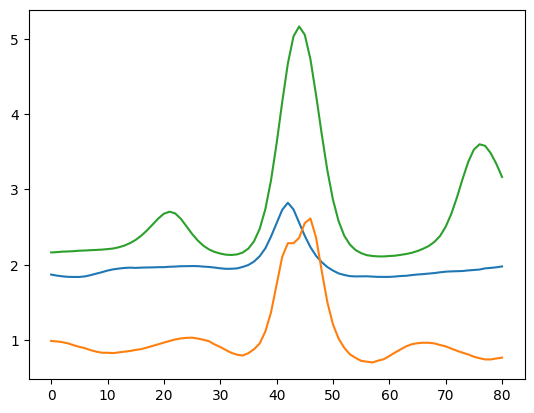

In [449]:
for flux,ivar in [(o3_fluxes, o3_ivars), (o2_fluxes, o2_ivars), (ha_fluxes, ha_ivars)]:
    fl = np.vstack(flux)
    iv = np.vstack(ivar)
    f = np.sum(fl * iv, axis=0) / np.sum(iv, axis=0)
    plt.plot(f);
#plt.show()

In [425]:
viewer_link(gals[1])

https://www.legacysurvey.org/viewer-desi/?ra=44.4742&dec=0.5999&zoom=15&mark=44.4742,0.5999


In [ ]:
# 3726-3729 [OII] lines
# 5007      [OIII]
# 6562      Halpha
# 6583      [NII]

In [426]:
b_wave.min(), b_wave.max(), z_wave.min(), z_wave.max()

(3600.0, 5800.0000000005, 7520.0, 9824.000000000524)

In [ ]:
#fns = glob('/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/dark/0/*/coadd-main-dark-*.fits')
#fns = [fn.replace('/redrock-', '/coadd-') for fn in fns]
co_dark_fns = [fn.replace('/redrock-', '/coadd-') for fn in rr_dark_fns]
fns = co_dark_fns
print(len(fns), 'files')
o3_fluxes = []
o3_ivars = []
o3_dists = []
o3_gal_targetids = []
o3_stuck_targetids = []

o2_fluxes = []
o2_ivars = []
o2_dists = []
o2_gal_targetids = []
o2_stuck_targetids = []

ha_fluxes = []
ha_ivars = []
ha_dists = []
ha_gal_targetids = []
ha_stuck_targetids = []

# 3726-3729 [OII] lines
# 6562      Halpha
# 6583      [NII]

targetid_map = dict([(t,i) for i,t in enumerate(sky_sample.targetid) if Imatch[i] is not None])
sample_targetids = list(targetid_map.keys())

for ifn,fn in enumerate(fns):
    if not os.path.exists(fn):
        continue
    fibermap = fits_table(fn)
    I = np.flatnonzero(np.isin(fibermap.targetid, sample_targetids))
    if len(I) == 0:
        continue
    F = fitsio.FITS(fn)
    targetids = fibermap.targetid[I]
    ras = fibermap.target_ra[I]
    decs = fibermap.target_dec[I]
    b_wave = F['B_WAVELENGTH'].read()
    b_flux = F['B_FLUX'].read()[I, :]
    b_ivar = F['B_IVAR'].read()[I, :]
    r_wave = F['R_WAVELENGTH'].read()
    r_flux = F['R_FLUX'].read()[I, :]
    r_ivar = F['R_IVAR'].read()[I, :]
    z_wave = F['Z_WAVELENGTH'].read()
    z_flux = F['Z_FLUX'].read()[I, :]
    z_ivar = F['Z_IVAR'].read()[I, :]
    for ispec,(targetid,ra,dec) in enumerate(zip(targetids, ras, decs)):
        isample = targetid_map[targetid]
        for igal in Imatch[isample]:
            z = gals.z[igal]
            # Book-keeping check: sky_sample & galaxy match; this fibermap row matches
            #print('Fibermap:', ra, 'Sky_sample:', sky_sample.target_ra[isample], 'gal:', gals.target_ra[igal])
            d = degrees_between(ra, dec, gals.target_ra[igal], gals.target_dec[igal])

            # [OII]
            target_restframe = 3726.
            target_wave = target_restframe * (1. + z)
            iwave = np.argmin(np.abs(b_wave - target_wave))
            S = 40
            #assert((iwave >= S) * (iwave < len(b_wave)-S))
            if (iwave >= S) and (iwave < len(b_wave)-S):
                f   = b_flux[ispec, iwave-S : iwave+S+1]
                fiv = b_ivar[ispec, iwave-S : iwave+S+1]
                o2_fluxes.append(f)
                o2_ivars.append(fiv)
                o2_dists.append(d)
                o2_gal_targetids.append(gals.targetid[igal])
                o2_stuck_targetids.append(targetid)

            # [OIII]
            target_restframe = 5007.
            target_wave = target_restframe * (1. + z)
            iwave = np.argmin(np.abs(r_wave - target_wave))
            S = 40
            #assert((iwave >= S) * (iwave < len(r_wave)-S))
            if (iwave >= S) and (iwave < len(r_wave)-S):
                f   = r_flux[ispec, iwave-S : iwave+S+1]
                fiv = r_ivar[ispec, iwave-S : iwave+S+1]
                o3_fluxes.append(f)
                o3_ivars.append(fiv)
                o3_dists.append(d)
                o3_gal_targetids.append(gals.targetid[igal])
                o3_stuck_targetids.append(targetid)

            # H-alpha
            target_restframe = 6562.
            target_wave = target_restframe * (1. + z)
            iwave = np.argmin(np.abs(z_wave - target_wave))
            S = 60
            #assert((iwave >= S) * (iwave < len(z_wave)-S))
            if (iwave >= S) and (iwave < len(r_wave)-S):
                f   = z_flux[ispec, iwave-S : iwave+S+1]
                fiv = z_ivar[ispec, iwave-S : iwave+S+1]
                ha_fluxes.append(f)
                ha_ivars.append(fiv)
                ha_dists.append(d)
                ha_gal_targetids.append(gals.targetid[igal])
                ha_stuck_targetids.append(targetid)
                

    if ifn % 10 == 0:
        print('.', end='')
        sys.stdout.flush()
print()

sky_o3_fluxes = np.vstack(o3_fluxes)
sky_o3_ivars  = np.vstack(o3_ivars)
sky_o3_dists  = np.hstack(o3_dists)
sky_o3_gal_targetids = np.hstack(o3_gal_targetids)
sky_o3_stuck_targetids = np.hstack(o3_stuck_targetids)

sky_o2_fluxes = np.vstack(o2_fluxes)
sky_o2_ivars  = np.vstack(o2_ivars)
sky_o2_dists  = np.hstack(o2_dists)
sky_o2_gal_targetids = np.hstack(o2_gal_targetids)
sky_o2_stuck_targetids = np.hstack(o2_stuck_targetids)

sky_ha_fluxes = np.vstack(ha_fluxes)
sky_ha_ivars  = np.vstack(ha_ivars)
sky_ha_dists  = np.hstack(ha_dists)
sky_ha_gal_targetids = np.hstack(ha_gal_targetids)
sky_ha_stuck_targetids = np.hstack(ha_stuck_targetids)

17908 files
..................................................................................................................................................................................................................................................................................................................................

In [38]:

sky_o3_fluxes = np.vstack(o3_fluxes)
sky_o3_ivars  = np.vstack(o3_ivars)
sky_o3_dists  = np.hstack(o3_dists)
sky_o2_fluxes = np.vstack(o2_fluxes)
sky_o2_ivars  = np.vstack(o2_ivars)
sky_o2_dists  = np.hstack(o2_dists)
sky_ha_fluxes = np.vstack(ha_fluxes)
sky_ha_ivars  = np.vstack(ha_ivars)
sky_ha_dists  = np.hstack(ha_dists)

In [ ]:
# legacypipe/py/399.py ...

In [4]:
X = pickle.load(open('/pscratch/sd/d/dstn/lines.pickle','rb'))

In [5]:
X.keys()

dict_keys(['sky_o3_fluxes', 'sky_o3_ivars', 'sky_o3_dists', 'sky_o3_gal_targetids', 'sky_o3_stuck_targetids', 'sky_o2_fluxes', 'sky_o2_ivars', 'sky_o2_dists', 'sky_o2_gal_targetids', 'sky_o2_stuck_targetids', 'sky_ha_fluxes', 'sky_ha_ivars', 'sky_ha_dists', 'sky_ha_gal_targetids', 'sky_ha_stuck_targetids', 'b_wave', 'r_wave', 'z_wave'])

In [6]:
sky_o3_fluxes = X['sky_o3_fluxes']
sky_o3_ivars  = X['sky_o3_ivars']
sky_o3_dists  = X['sky_o3_dists']
sky_o2_fluxes = X['sky_o2_fluxes']
sky_o2_ivars  = X['sky_o2_ivars']
sky_o2_dists  = X['sky_o2_dists']
sky_ha_fluxes = X['sky_ha_fluxes']
sky_ha_ivars  = X['sky_ha_ivars']
sky_ha_dists  = X['sky_ha_dists']
b_wave = X['b_wave']
r_wave = X['r_wave']
z_wave = X['z_wave']

In [11]:
sky_o3_gal_targetids = X['sky_o3_gal_targetids']
sky_o2_gal_targetids = X['sky_o2_gal_targetids']
sky_ha_gal_targetids = X['sky_ha_gal_targetids']

In [12]:
gals = fits_table('/pscratch/sd/d/dstn/galaxy-sample-sub.fits')

In [13]:
gal_targetid_map = dict([(t,i) for i,t in enumerate(gals.targetid)])

In [29]:
len(gals)

9571025

In [7]:
sky_o3_fluxes.shape, sky_o2_fluxes.shape, sky_ha_fluxes.shape

((11398060, 81), (11716985, 81), (10772526, 121))

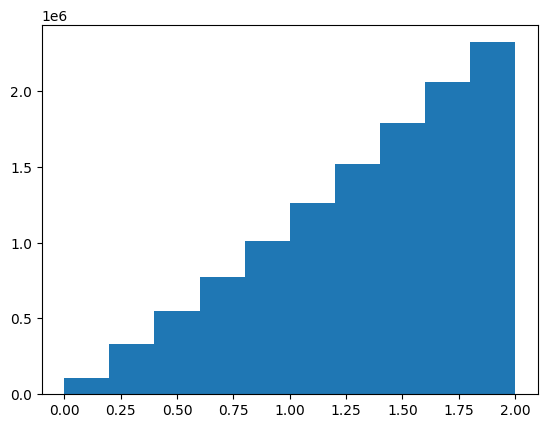

In [8]:
plt.hist(sky_o2_dists * 60.);

In [9]:
o2_dw = b_wave[1] - b_wave[0]
o2_nw = sky_o2_fluxes.shape[1]
o2_delta_wave = o2_dw * (np.arange(o2_nw) - o2_nw//2)

o3_dw = r_wave[1] - r_wave[0]
o3_nw = sky_o3_fluxes.shape[1]
o3_delta_wave = o3_dw * (np.arange(o3_nw) - o3_nw//2)

ha_dw = z_wave[1] - z_wave[0]
ha_nw = sky_ha_fluxes.shape[1]
ha_delta_wave = ha_dw * (np.arange(ha_nw) - ha_nw//2)

0.25 arcmin: 171309 OII 166653 OIII 157607 Halpha
0.5 arcmin: 685637 OII 666756 OIII 630271 Halpha
1.0 arcmin: 2771355 OII 2695888 OIII 2548223 Halpha


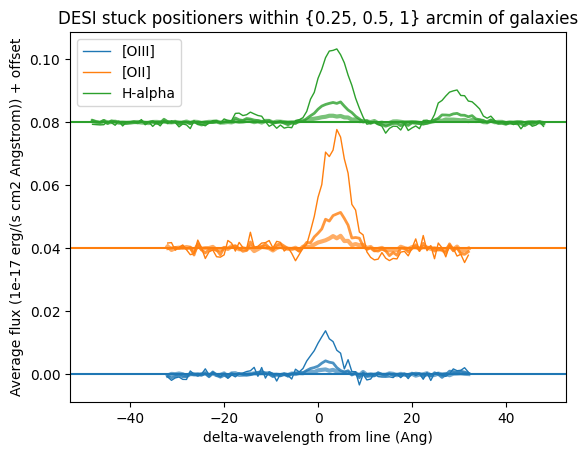

In [28]:
cc = []
dists = [0.25, 0.5, 1.]
for idist,d in enumerate(dists):
    dmax = d/60.
    I_o2 = np.flatnonzero(sky_o2_dists < dmax)
    I_o3 = np.flatnonzero(sky_o3_dists < dmax)
    I_ha = np.flatnonzero(sky_ha_dists < dmax)
    print(d, 'arcmin:', len(I_o2), 'OII', len(I_o3), 'OIII', len(I_ha), 'Halpha')
    for i,(flux,ivar,dwave,label) in enumerate([
        (sky_o3_fluxes[I_o3], sky_o3_ivars[I_o3], o3_delta_wave, '[OIII]'),
        (sky_o2_fluxes[I_o2], sky_o2_ivars[I_o2], o2_delta_wave, '[OII]'),
        (sky_ha_fluxes[I_ha], sky_ha_ivars[I_ha], ha_delta_wave, 'H-alpha')]):
        f = np.sum(flux * ivar, axis=0) / np.sum(ivar, axis=0)
        medf = np.median(f)
        kwa = {}
        if idist != 0:
            kwa.update(color=cc[i])
        else:
            kwa.update(label=label)
        kwa.update(alpha=0.8**idist, lw=1+idist)
        p1 = plt.plot(dwave, f - medf + i*0.04, **kwa)
        if idist == 0:
            plt.axhline(i*0.04, color=p1[0].get_color())
            cc.append(p1[0].get_color())
            
plt.legend()
plt.xlabel('delta-wavelength from line (Ang)')
plt.ylabel('Average flux (1e-17 erg/(s cm2 Angstrom)) + offset')
plt.title('DESI stuck positioners within {%s} arcmin of galaxies' % (', '.join(['%g' % d for d in dists])))
plt.savefig('stuck4.png')

In [17]:
o2_gal_z = np.array([gals.z[gal_targetid_map[t]] for t in sky_o2_gal_targetids])
o3_gal_z = np.array([gals.z[gal_targetid_map[t]] for t in sky_o3_gal_targetids])
ha_gal_z = np.array([gals.z[gal_targetid_map[t]] for t in sky_ha_gal_targetids])

In [16]:
#np.percentile(o3_gal_z, [0,25,50,75,100])
np.percentile(o3_gal_z, [0,33.3,66.6,100])

array([0.15670066, 0.23086617, 0.31293722, 0.49999995])

z 0.15 to 0.23 : 238767 OII 219886 OIII 229472 Halpha
z 0.23 to 0.31 : 217864 OII 217864 OIII 217864 Halpha
z 0.31 to 0.5 : 229006 OII 229006 OIII 182935 Halpha


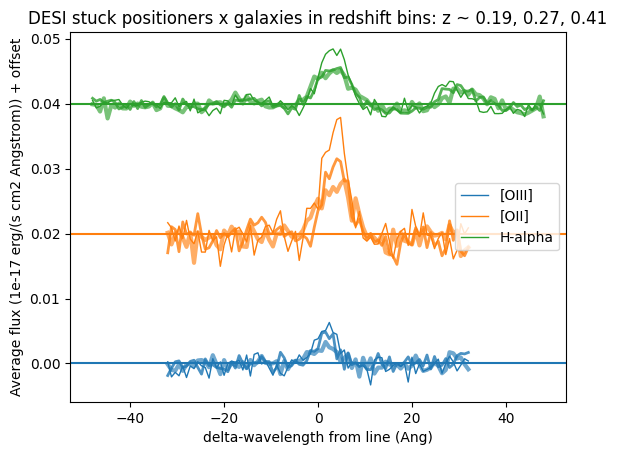

In [27]:
cc = []
dmax = 0.5 / 60
zbins = [0.15, 0.23, 0.31, 0.5]
zm = []
for iz,(zlo,zhi) in enumerate(zip(zbins, zbins[1:])):
    zm.append((zlo+zhi)/2.)
    I_o2 = np.flatnonzero((sky_o2_dists < dmax) * (o2_gal_z > zlo) * (o2_gal_z <= zhi))
    I_o3 = np.flatnonzero((sky_o3_dists < dmax) * (o3_gal_z > zlo) * (o3_gal_z <= zhi))
    I_ha = np.flatnonzero((sky_ha_dists < dmax) * (ha_gal_z > zlo) * (ha_gal_z <= zhi))
    print('z', zlo, 'to', zhi, ':', len(I_o2), 'OII', len(I_o3), 'OIII', len(I_ha), 'Halpha')
    for i,(flux,ivar,dwave,label) in enumerate([
        (sky_o3_fluxes[I_o3], sky_o3_ivars[I_o3], o3_delta_wave, '[OIII]'),
        (sky_o2_fluxes[I_o2], sky_o2_ivars[I_o2], o2_delta_wave, '[OII]'),
        (sky_ha_fluxes[I_ha], sky_ha_ivars[I_ha], ha_delta_wave, 'H-alpha')]):
        f = np.sum(flux * ivar, axis=0) / np.sum(ivar, axis=0)
        medf = np.median(f)
        kwa = {}
        if iz != 0:
            kwa.update(color=cc[i])
        else:
            kwa.update(label=label)
        kwa.update(alpha=0.8**iz, lw=1+iz)
        p1 = plt.plot(dwave, f - medf + i*0.02, **kwa)
        if iz == 0:
            plt.axhline(i*0.02, color=p1[0].get_color())
            cc.append(p1[0].get_color())
            
plt.legend()
plt.xlabel('delta-wavelength from line (Ang)')
plt.ylabel('Average flux (1e-17 erg/(s cm2 Angstrom)) + offset')
plt.title('DESI stuck positioners x galaxies in redshift bins: z ~ %s' % (', '.join(['%.2f' % z for z in zm])))
plt.savefig('stuck5.png')

In [43]:
def masked_median(flux, ivar):
    n_wave = flux.shape[1]
    sn_med = np.zeros(n_wave)
    flux_med = np.zeros(n_wave)
    for i in range(n_wave):
        nz = np.flatnonzero(ivar[:,i])
        if len(nz) == 0:
            continue
        sn_med[i] = np.median(flux[nz,i] * np.sqrt(ivar[nz,i]))
        flux_med[i] = np.median(flux[nz,i])
    return sn_med, flux_med

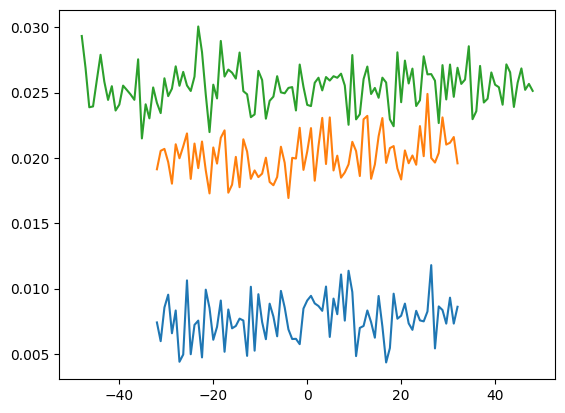

In [44]:
o2_sn_med, o2_flux_med = masked_median(sky_o2_fluxes, sky_o2_ivars)
o3_sn_med, o3_flux_med = masked_median(sky_o3_fluxes, sky_o3_ivars)
ha_sn_med, ha_flux_med = masked_median(sky_ha_fluxes, sky_ha_ivars)
plt.plot(o2_delta_wave, o2_sn_med)
plt.plot(o3_delta_wave, o3_sn_med)
plt.plot(ha_delta_wave, ha_sn_med);

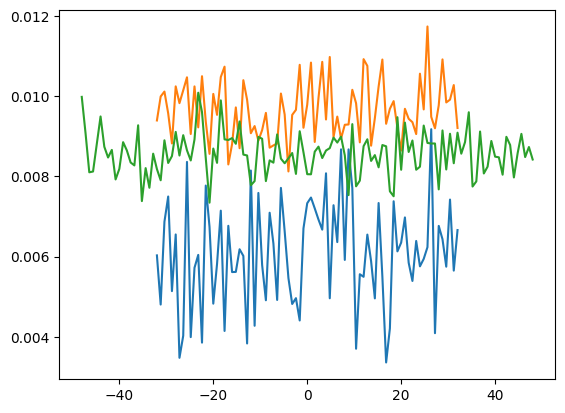

In [45]:
plt.plot(o2_delta_wave, o2_flux_med)
plt.plot(o3_delta_wave, o3_flux_med)
plt.plot(ha_delta_wave, ha_flux_med);

In [ ]:
### OLD
r_fluxes_1 = []
r_ivars_1 = []

r_fluxes_2 = []
r_ivars_2 = []

for fn in fns:
    fibermap = fits_table(fn)
    I = np.flatnonzero(np.isin(fibermap.targetid, stuck_targetids))
    if len(I) == 0:
        continue
    F = fitsio.FITS(fn)

    targetids = fibermap.targetid[I]
    ras = fibermap.target_ra[I]
    decs = fibermap.target_dec[I]
    r_wave = F['R_WAVELENGTH'].read()
    r_flux = F['R_FLUX'].read()[I, :]
    r_ivar = F['R_IVAR'].read()[I, :]
    #r_mask = F['R_MASK'].read()[I, :]

    # [OIII]
    target_restframe = 5007.
    
    for ispec,(targetid,ra,dec) in enumerate(zip(targetids, ras, decs)):
        istuck = targetid_map[targetid]
        for igal in Imatch[istuck]:
            z = gals.z[igal]
            target_wave = target_restframe * (1. + z)
            iwave = np.argmin(np.abs(r_wave - target_wave))
            S = 40
            assert((iwave >= S) * (iwave < len(r_wave)-S))
            r   = r_flux[ispec, iwave-S : iwave+S+1]
            riv = r_ivar[ispec, iwave-S : iwave+S+1]
            if degrees_between(ra, dec, gals.target_ra[igal], gals.target_dec[igal]) <= med_dist:
                r_fluxes_1.append(r)
                r_ivars_1.append(riv)
            else:
                r_fluxes_2.append(r)
                r_ivars_2.append(riv)
    print('.', end='')
    sys.stdout.flush()
print()
len(r_fluxes_1), len(r_fluxes_2)

In [372]:
r_fluxes_1[0].shape

(81,)

In [373]:
r_fluxes_1 = np.vstack(r_fluxes_1)
r_ivars_1 = np.vstack(r_ivars_1)
r_fluxes_2 = np.vstack(r_fluxes_2)
r_ivars_2 = np.vstack(r_ivars_2)

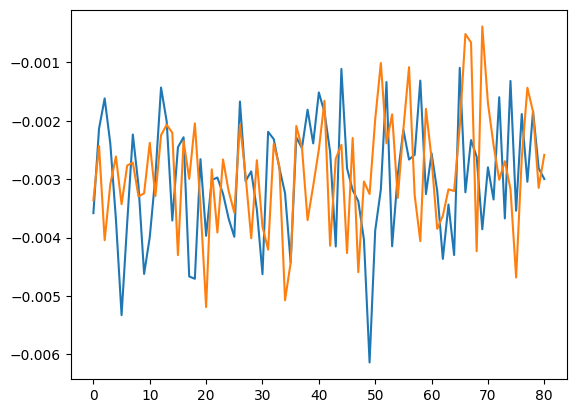

In [375]:
rf1 = np.sum(r_fluxes_1 * r_ivars_1, axis=0) / np.sum(r_ivars_1, axis=0)
rf2 = np.sum(r_fluxes_2 * r_ivars_2, axis=0) / np.sum(r_ivars_2, axis=0)
plt.plot(rf1)
plt.plot(rf2);

In [376]:
n_wave = r_fluxes_1.shape[1]
r1_sn_med = np.zeros(n_wave)
r2_sn_med = np.zeros(n_wave)
r1_flux_med = np.zeros(n_wave)
r2_flux_med = np.zeros(n_wave)
for i in range(n_wave):
    nz = np.flatnonzero(r_ivars_1[:,i])
    if len(nz) == 0:
        continue
    r1_sn_med[i] = np.median(r_fluxes_1[nz,i] * np.sqrt(r_ivars_1[nz,i]))
    r1_flux_med[i] = np.median(r_fluxes_1[nz,i])

    nz = np.flatnonzero(r_ivars_2[:,i])
    if len(nz) == 0:
        continue
    r2_sn_med[i] = np.median(r_fluxes_2[nz,i] * np.sqrt(r_ivars_2[nz,i]))
    r2_flux_med[i] = np.median(r_fluxes_2[nz,i])


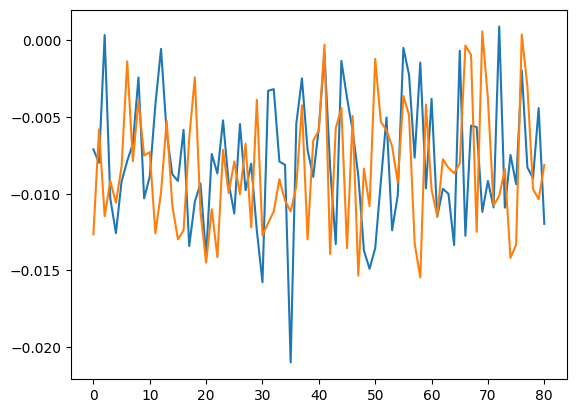

In [378]:
plt.plot(r1_sn_med)
plt.plot(r2_sn_med);

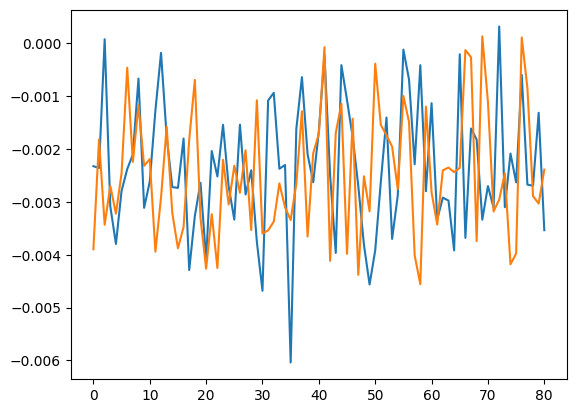

In [379]:
plt.plot(r1_flux_med)
plt.plot(r2_flux_med);

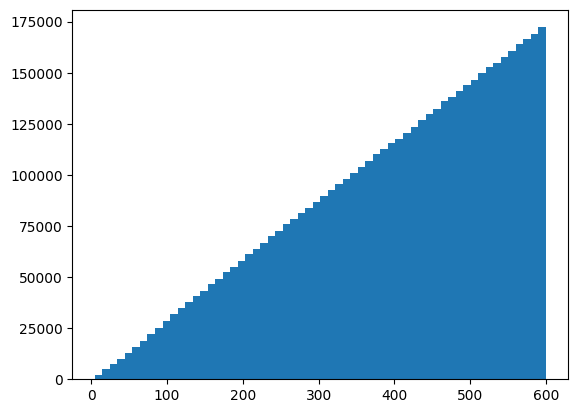

In [329]:
plt.hist(d * 3600., bins=60);

In [330]:
i = np.argmin(d)
viewer_link(stuck_sky[I[i]])

https://www.legacysurvey.org/viewer-desi/?ra=31.1503&dec=15.4026&zoom=15&mark=31.1503,15.4026


In [204]:
#ii = np.flatnonzero(d < 1./60)
#jj = np.flatnonzero((d > 1./60) * (d < 2./60))
#len(ii), len(jj)

(9019, 29623)

In [270]:
kk = np.argsort(d)
ii = kk[:20000]
jj = kk[-20000:]

In [271]:
gal_match_1 = gals[J[ii]]
gal_match_2 = gals[J[jj]]
stuck_match_1 = stuck_sky[I[ii]]
stuck_match_2 = stuck_sky[J[jj]]

In [272]:
len(stuck_match_1), len(stuck_match_2), len(gal_match_1), len(gal_match_2)

(20000, 20000, 20000, 20000)

In [273]:
len(np.unique(I[ii])), len(np.unique(I[jj]))

(14555, 15925)

In [274]:
stuck_match_tids = set(stuck_match_1.targetid).union(stuck_match_2.targetid)

In [275]:
#fns = glob('/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/dark/0/*/coadd-main-dark-*.fits')
fns = [fn.replace('/redrock-', '/coadd-') for fn in fns]
print(len(fns), 'files')

b_fluxes = []
b_waves = []
b_ivars = []
r_fluxes = []
r_waves = []
r_ivars = []
z_fluxes = []
z_waves = []
z_ivars = []
spec_tids = []

for fn in fns:
    fibermap = fits_table(fn)
    I = np.flatnonzero(np.isin(fibermap.targetid, list(stuck_match_tids)))
    if len(I) == 0:
        continue
    spec_tids.append(fibermap.targetid[I])
    F = fitsio.FITS(fn)
    b_wave = F['B_WAVELENGTH'].read()
    b_flux = F['B_FLUX'].read()[I, :]
    b_ivar = F['B_IVAR'].read()[I, :]
    b_mask = F['B_MASK'].read()[I, :]
    
    r_wave = F['R_WAVELENGTH'].read()
    r_flux = F['R_FLUX'].read()[I, :]
    r_ivar = F['R_IVAR'].read()[I, :]
    r_mask = F['R_MASK'].read()[I, :]
    
    z_wave = F['Z_WAVELENGTH'].read()
    z_flux = F['Z_FLUX'].read()[I, :]
    z_ivar = F['Z_IVAR'].read()[I, :]
    z_mask = F['Z_MASK'].read()[I, :]

    #print('Masked ivars:', z_ivar[z_mask != 0])
    assert(np.all(b_ivar[b_mask != 0] == 0))
    assert(np.all(r_ivar[r_mask != 0] == 0))
    assert(np.all(z_ivar[z_mask != 0] == 0))

    b_waves.append(b_wave)
    b_fluxes.append(b_flux)
    b_ivars.append(b_ivar)
    r_waves.append(r_wave)
    r_fluxes.append(r_flux)
    r_ivars.append(r_ivar)
    z_waves.append(z_wave)
    z_fluxes.append(z_flux)
    z_ivars.append(z_ivar)
    #print('Read', len(I), 'spectra from', fn)    
    print('.', end='')
    sys.stdout.flush()
print()
#coadd_fibermap = merge_tables([fits_table(fn) for fn in fns])
#fibermap = merge_tables([fits_table(fn, hdu=2) for fn in fns])
#len(coadd_fibermap)

405 files
...........................................................................................................................................................................................................................................................................................................................................................................................


In [276]:
assert(all([w == b_waves[0] for w in b_waves]))
assert(all([w == r_waves[0] for w in r_waves]))
assert(all([w == z_waves[0] for w in z_waves]))

In [277]:
b_wave = b_waves[0]
r_wave = r_waves[0]
z_wave = z_waves[0]

In [278]:
b_flux = np.vstack(b_fluxes)
b_ivar = np.vstack(b_ivars)
r_flux = np.vstack(r_fluxes)
r_ivar = np.vstack(r_ivars)
z_flux = np.vstack(z_fluxes)
z_ivar = np.vstack(z_ivars)

In [279]:
spec_tids = np.hstack(spec_tids)

In [280]:
n_spec = b_flux.shape[0]
n_spec

20436

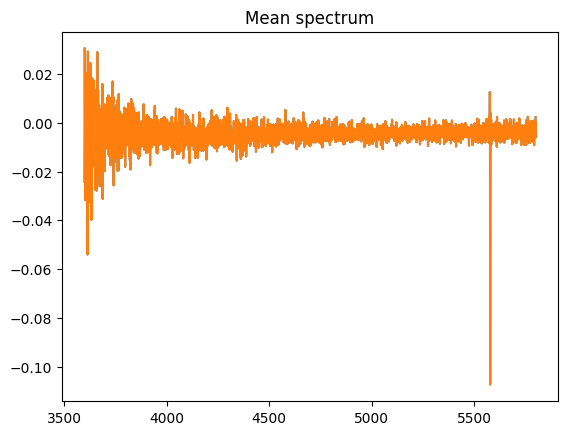

In [281]:
b_mean = np.sum(b_flux * b_ivar, axis=0) / np.sum(b_ivar, axis=0)
b_sn_med = np.median(b_flux * np.sqrt(b_ivar), axis=0)

plt.plot(b_wave, b_mean)
plt.plot(b_wave, b_mean)
plt.title('Mean spectrum');

#for i in range(n_spec):
#    plt.plot(b_wave, b_flux[i,:], alpha=0.1);

In [282]:
n_wave = b_flux.shape[1]
b_sn_med = np.zeros(n_wave)
b_ivar_med = np.zeros(n_wave)
for i in range(n_wave):
    nz = np.flatnonzero(b_ivar[i,:])
    if len(nz) == 0:
        continue
    b_sn_med[i] = np.median(b_flux[i,nz] * np.sqrt(b_ivar[i,nz]))
    b_ivar_med[i] = np.median(b_ivar[i,nz])

In [283]:
n_r_wave = r_flux.shape[1]
n_z_wave = z_flux.shape[1]

r_sn_med = np.zeros(n_r_wave)
r_ivar_med = np.zeros(n_r_wave)
z_sn_med = np.zeros(n_z_wave)
z_ivar_med = np.zeros(n_z_wave)
for i in range(n_r_wave):
    nz = np.flatnonzero(r_ivar[i,:])
    if len(nz) == 0:
        continue
    r_sn_med[i] = np.median(r_flux[i,nz] * np.sqrt(r_ivar[i,nz]))
    r_ivar_med[i] = np.median(r_ivar[i,nz])
for i in range(n_z_wave):
    nz = np.flatnonzero(z_ivar[i,:])
    if len(nz) == 0:
        continue
    z_sn_med[i] = np.median(z_flux[i,nz] * np.sqrt(z_ivar[i,nz]))
    z_ivar_med[i] = np.median(z_ivar[i,nz])    

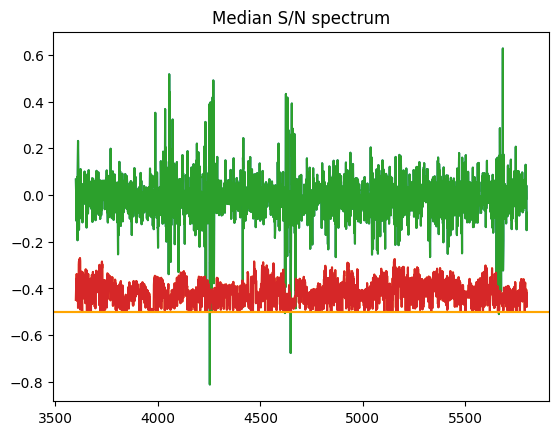

In [284]:
plt.plot(b_wave, b_sn_med)
plt.plot(b_wave, -0.5 + 0.02*b_ivar_med)
plt.axhline(-0.5, color='orange')
plt.title('Median S/N spectrum');plt.plot(b_wave, b_sn_med)
plt.plot(b_wave, -0.5 + 0.02*b_ivar_med)
plt.axhline(-0.5, color='orange')
plt.title('Median S/N spectrum');

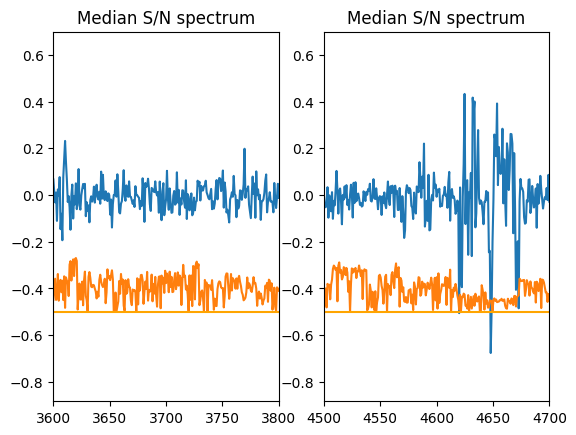

In [285]:
plt.subplot(1,2,1)
plt.plot(b_wave, b_sn_med)
plt.plot(b_wave, -0.5 + 0.02*b_ivar_med)
plt.axhline(-0.5, color='orange')
plt.title('Median S/N spectrum')
plt.xlim(3600, 3800);
plt.subplot(1,2,2)
plt.plot(b_wave, b_sn_med)
plt.plot(b_wave, -0.5 + 0.02*b_ivar_med)
plt.axhline(-0.5, color='orange')
plt.title('Median S/N spectrum')
plt.xlim(4500, 4700);

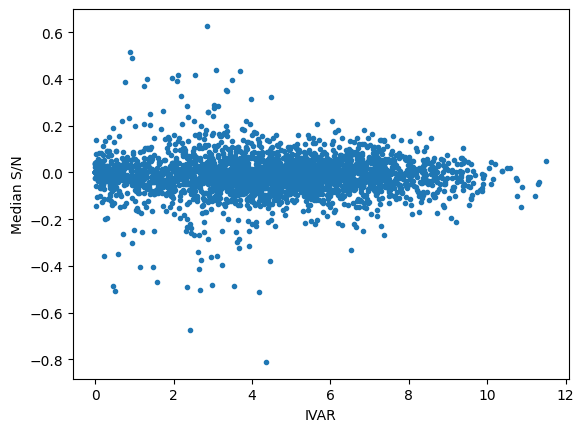

In [286]:
plt.plot(b_ivar_med, b_sn_med, '.');
plt.xlabel('IVAR')
plt.ylabel('Median S/N');

In [287]:
from scipy.ndimage import gaussian_filter

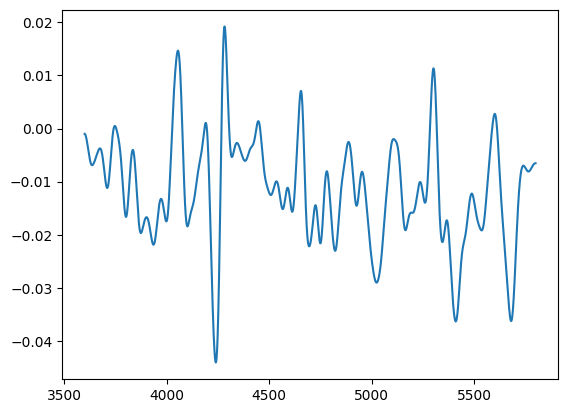

In [288]:
plt.plot(b_wave, gaussian_filter(b_sn_med, 20.));

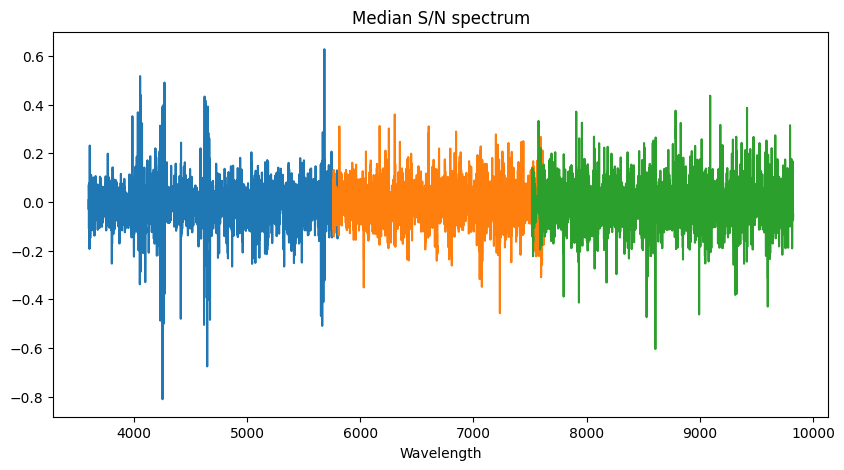

In [289]:
plt.figure(figsize=(10,5))
plt.plot(b_wave, b_sn_med)
#plt.plot(b_wave, -0.5 + 0.02*b_ivar_med)
#plt.axhline(-0.5, color='orange')
plt.plot(r_wave, r_sn_med)
plt.plot(z_wave, z_sn_med)
plt.title('Median S/N spectrum');
plt.xlabel('Wavelength');


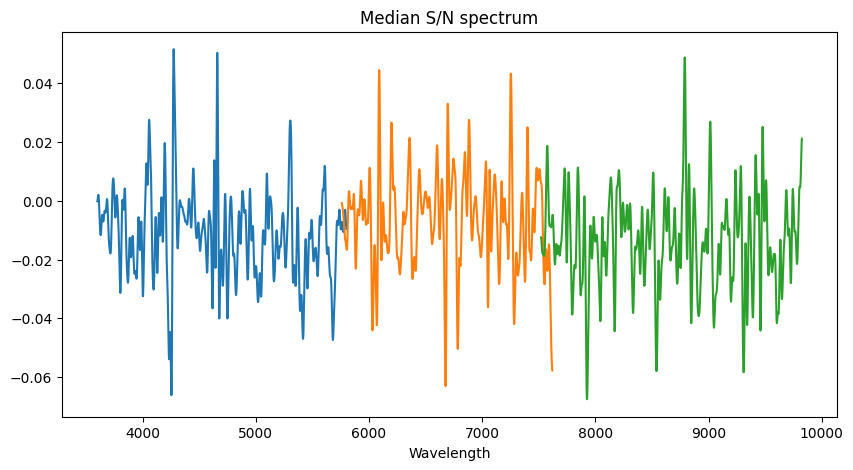

In [290]:
plt.figure(figsize=(10,5))
sig = 10
plt.plot(b_wave, gaussian_filter(b_sn_med, sig))
#plt.plot(b_wave, -0.5 + 0.02*b_ivar_med)
#plt.axhline(-0.5, color='orange')
plt.plot(r_wave, gaussian_filter(r_sn_med, sig))
plt.plot(z_wave, gaussian_filter(z_sn_med, sig))
plt.title('Median S/N spectrum');
plt.xlabel('Wavelength');

In [346]:
r_wave.min(), r_wave.max(), b_wave.max()

(5760.0, 7620.000000000423, 5800.0000000005)

In [291]:
n_b_wave = n_wave

In [292]:
b_flux.shape, b_ivar.shape

((20436, 2751), (20436, 2751))

In [293]:
len(spec_tids)

20436

In [294]:
n_b_wave, n_r_wave, n_z_wave

(2751, 2326, 2881)

In [295]:
I1 = np.flatnonzero(np.isin(spec_tids, stuck_match_1.targetid))
I2 = np.flatnonzero(np.isin(spec_tids, stuck_match_2.targetid))
print(len(I1), 'inner radius and', len(I2), 'outer radius')
b_sn_med_1 = np.zeros(n_b_wave)
b_sn_med_2 = np.zeros(n_b_wave)
r_sn_med_1 = np.zeros(n_r_wave)
r_sn_med_2 = np.zeros(n_r_wave)
z_sn_med_1 = np.zeros(n_z_wave)
z_sn_med_2 = np.zeros(n_z_wave)
for i in range(n_b_wave):
    nz = I1[b_ivar[I1,i] > 0]
    if len(nz):
        b_sn_med_1[i] = np.median(b_flux[nz,i] * np.sqrt(b_ivar[nz,i]))
    nz = I2[b_ivar[I2,i] > 0]
    if len(nz):
        b_sn_med_2[i] = np.median(b_flux[nz,i] * np.sqrt(b_ivar[nz,i]))
for i in range(n_r_wave):
    nz = I1[r_ivar[I1,i] > 0]
    if len(nz):
        r_sn_med_1[i] = np.median(r_flux[nz,i] * np.sqrt(r_ivar[nz,i]))
    nz = I2[r_ivar[I2,i] > 0]
    if len(nz):
        r_sn_med_2[i] = np.median(r_flux[nz,i] * np.sqrt(r_ivar[nz,i]))       
for i in range(n_z_wave):
    nz = I1[z_ivar[I1,i] > 0]
    if len(nz):
        z_sn_med_1[i] = np.median(z_flux[nz,i] * np.sqrt(z_ivar[nz,i]))
    nz = I2[z_ivar[I2,i] > 0]
    if len(nz):
        z_sn_med_2[i] = np.median(z_flux[nz,i] * np.sqrt(z_ivar[nz,i]))        

14555 inner radius and 6712 outer radius


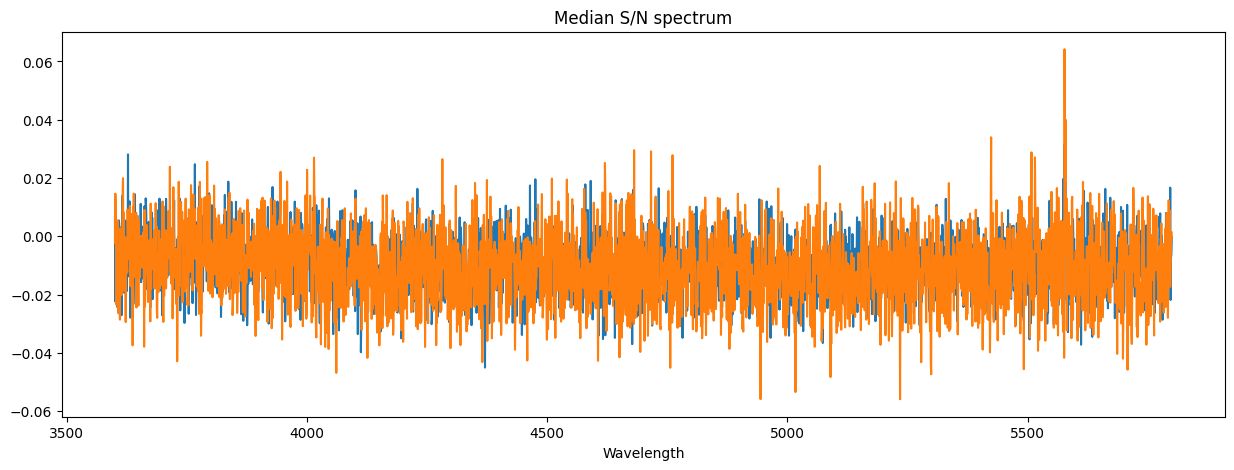

In [296]:
plt.figure(figsize=(15,5))
plt.plot(b_wave, b_sn_med_1)
plt.plot(b_wave, b_sn_med_2)
#plt.plot(r_wave, gaussian_filter(r_sn_med, sig))
#plt.plot(z_wave, gaussian_filter(z_sn_med, sig))
plt.title('Median S/N spectrum');
plt.xlabel('Wavelength');

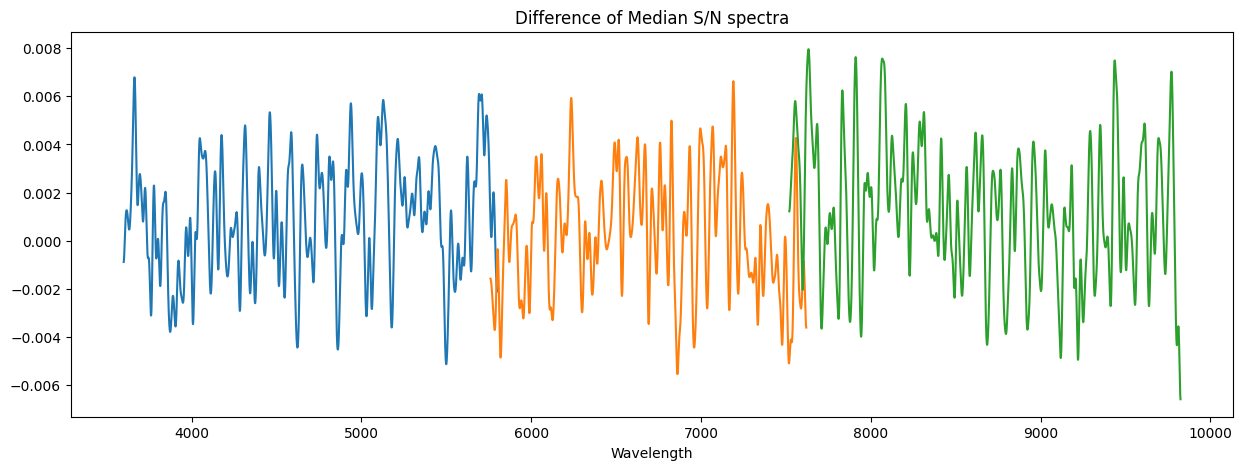

In [297]:
plt.figure(figsize=(15,5))
s = 10
plt.plot(b_wave, gaussian_filter(b_sn_med_1 - b_sn_med_2, s))
plt.plot(r_wave, gaussian_filter(r_sn_med_1 - r_sn_med_2, s))
plt.plot(z_wave, gaussian_filter(z_sn_med_1 - z_sn_med_2, s))
plt.title('Difference of Median S/N spectra');
plt.xlabel('Wavelength');